In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression

sns.set()

In [8]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


In [3]:
# df_log = df
# df_log['CLIENT_OUT'] = np.log1p(df_log['CLIENT_OUT'])

## Creating pivot table

In [122]:
df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE', margins=True, margins_name='All')

In [112]:
df_pivot.head()

DATE,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,All
ATM_ID,,,,,,,,,,,,,,,,,,,,,
0,91600,136500,335400,379000,344100,575300,158200,296500,453400,415900,...,543500,501600,538900,387200,591400,160400,195100,732100,629700,438624.425887
2,0,0,0,0,0,0,3000,14700,13300,0,...,13700,4600,27900,33100,33100,0,0,24000,12300,48425.991649
3,1200,2200,12100,18000,700,3000,18600,19900,7400,4100,...,194400,254500,247400,302400,360700,3000,1700,115600,229300,269204.175365
4,188400,223000,382000,459400,306400,199900,259500,190500,317500,331500,...,562400,1042800,642500,830400,756000,117100,0,511000,509000,513868.162839
5,64900,87700,159100,155300,175100,119700,137400,115800,195800,104300,...,411800,339900,264500,440200,362000,0,0,0,0,319809.394572


## Finding changes

## CreatingNewPivotTablePROD

In [48]:
def PlotWithChanges(df, df_zeroes_window, index=0, plot=True):
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    df_zeroes = FindZeroes(df_pivot, window_size=df_zeroes_window)
    
    zeroes = df_zeroes.loc[index, :].values
        
    if plot:
        plt.figure(figsize=(15, 15))
        plt.plot(df_pivot.loc[index, :].values / df_pivot.loc[index, :].values.mean())

        plt.plot(zeroes)
        plt.show()
    
    return ReturnRangesForChanges(zeroes, df_zeroes_window)

In [18]:
def FindZeroes(df_pivot, window_size):
    return df_pivot.T.rolling(window=window_size).mean().T == 0

def ReturnRangesForChanges(zeroes_list, zeroes_window):
    ranges = []

    start_iter = 0
    live = True

    for i, x in enumerate(zeroes_list):
        if live:
            if x == 1:
                ranges.append([start_iter, i - zeroes_window + 1])
                live = False
        else:
            if x == 0:
                start_iter = i
                live = True

    ranges.append([start_iter, i])
    
    return ranges



def ChangeFirstZeroesToNone(row):
    index = row.nonzero()[0][0]
    row[:index] = None
    return row

In [14]:
def CreatingNewPivotTable_TRAIN_ONLY(df, window_size=15):
    
    ids = np.unique(df.ATM_ID)
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    
    # remove first zeroes
    df_pivot = df_pivot.apply(ChangeFirstZeroesToNone, axis=1)
    
    
    df_zeroes = FindZeroes(df_pivot, window_size=window_size)
    
    final_pivot = pd.DataFrame(columns=df_pivot.columns)
    
    counter = 0
    for i in ids:
        zeroes = df_zeroes.loc[i, :].values
        ranges = ReturnRangesForChanges(zeroes, window_size)
                
        for index, range_ in enumerate(ranges):
            if range_[1] - range_[0] <  30:
                continue
            
            data = df_pivot.loc[i, :].copy()
            data[:range_[0]] = None
            data[range_[1]:] = None
#             print(range_, counter)
            final_pivot.loc[counter, :] = data
    
            counter += 1
            

    del df_zeroes
    
    
    # from pivot back to long df
    final_df = final_pivot.stack().reset_index()
    del final_pivot
    
    final_df = final_df[['DATE', 'level_0', 0]]
    final_df.columns = df.columns
    
    return final_df

In [50]:
from collections import defaultdict

def CreatingNewPivotTable_TEST(df, window_size=15):
    ids = np.unique(df.ATM_ID)
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    
    df
    # remove first zeroes
    df_pivot = df_pivot.apply(ChangeFirstZeroesToNone, axis=1)
    
    
    df_zeroes = FindZeroes(df_pivot, window_size=window_size)
    
    final_pivot = pd.DataFrame(columns=df_pivot.columns)
    
    
    is_small = defaultdict(lambda :  False)
    renumerate_dict = {}
    
    
    counter = 0
    for i in ids:
        zeroes = df_zeroes.loc[i, :].values
        ranges = ReturnRangesForChanges(zeroes, window_size)
        
        if ranges[-1][1] - ranges[-1][0] < 30:
            print(i, ranges)
            ranges[-1][0] = ranges[-2][0]
            is_small[i] = True
            
        renumerate_dict[counter] = i
        
        ranges = ranges[-1:]
        for index, range_ in enumerate(ranges):
            if range_[1] - range_[0] <  30:
                raise "CreatingNewPivotTable_TEST failed, call Sasha!!!"
            
            
            data = df_pivot.loc[i, :].copy()
            data[:range_[0]] = None
            data[range_[1]:] = None
#             print(range_, counter)
            final_pivot.loc[counter, :] = data
    
            counter += 1
        

    del df_zeroes
    
    
    # from pivot back to long df
    final_df = final_pivot.stack().reset_index()
    del final_pivot
    
    final_df = final_df[['DATE', 'level_0', 0]]
    final_df.columns = df.columns
    
    final_df.ATM_ID = final_df.ATM_ID.map(renumerate_dict)
    
    return final_df, is_small

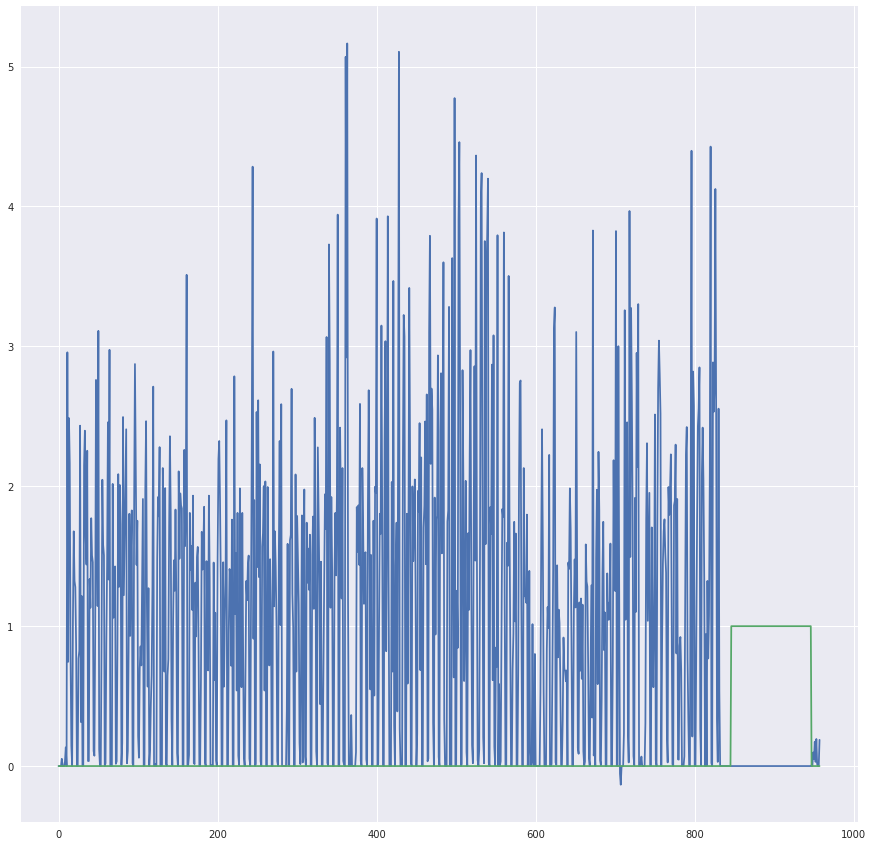

[[0, 832], [947, 957]]

In [52]:
PlotWithChanges(df, 15, 239)

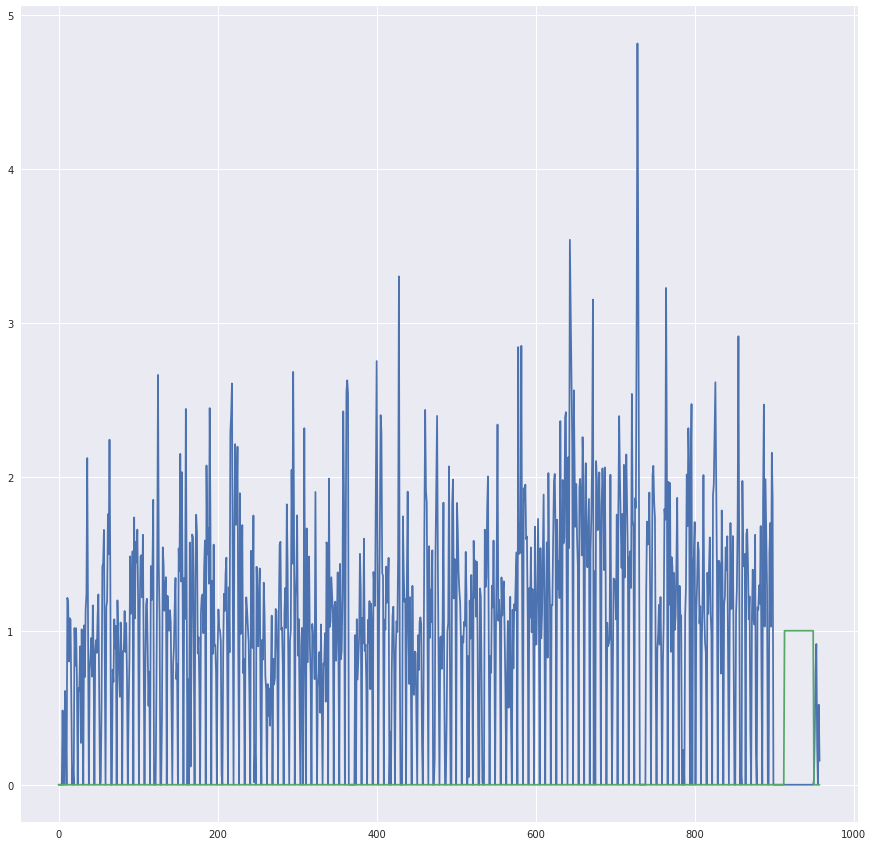

[[0, 899], [950, 957]]

In [53]:
PlotWithChanges(df, 15, 326)

In [ ]:
df

In [51]:
%time
pivot_final_test, is_small = CreatingNewPivotTable_TEST(df, window_size=15)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 17.4 µs
239 [[0, 832], [947, 957]]
326 [[0, 899], [950, 957]]


In [15]:
%time
pivot_final = CreatingNewPivotTable_TRAIN_ONLY(df, window_size=15)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs


In [16]:
pivot_final

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100
5,2015-01-06,0,575300
6,2015-01-07,0,158200
7,2015-01-08,0,296500
8,2015-01-09,0,453400
9,2015-01-10,0,415900


In [37]:
pivot_final.fillna(0, inplace=True)

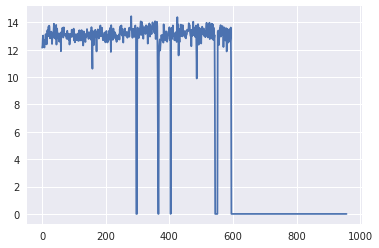

In [16]:
plt.plot(pivot_final.loc[3, :].values)
plt.show()

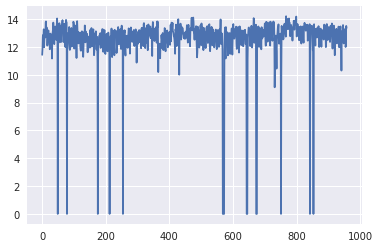

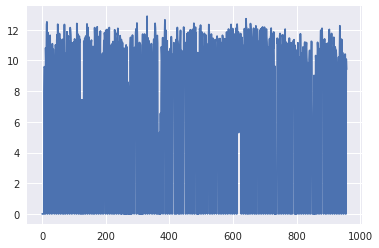

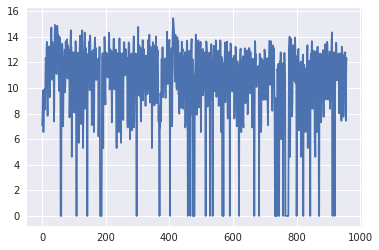

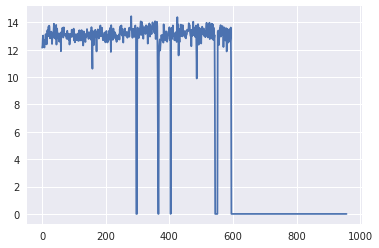

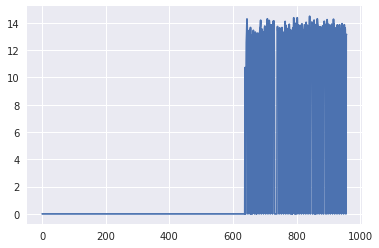

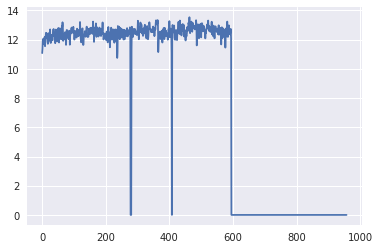

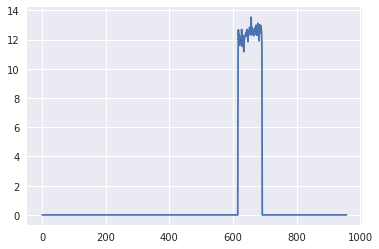

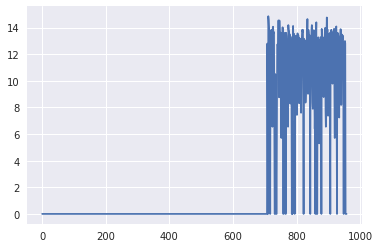

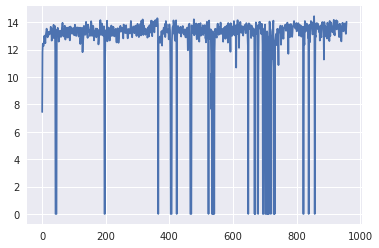

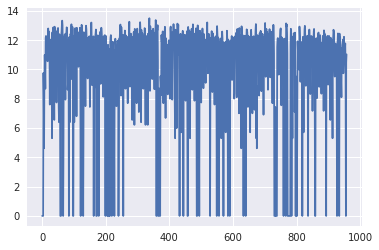

In [38]:
for x in range(10):
    plt.plot(pivot_final.loc[x, :].values)
    plt.show()

In [164]:
PlotWithChanges(5, plot=False)

[[0, 599], [616, 696], [708, 960]]

## Changes hardcoded first 60 only

In [165]:
for i in ids:
    df_pivot.loc[i, 'changes_new'] = len(PlotWithChanges(i, plot=False))

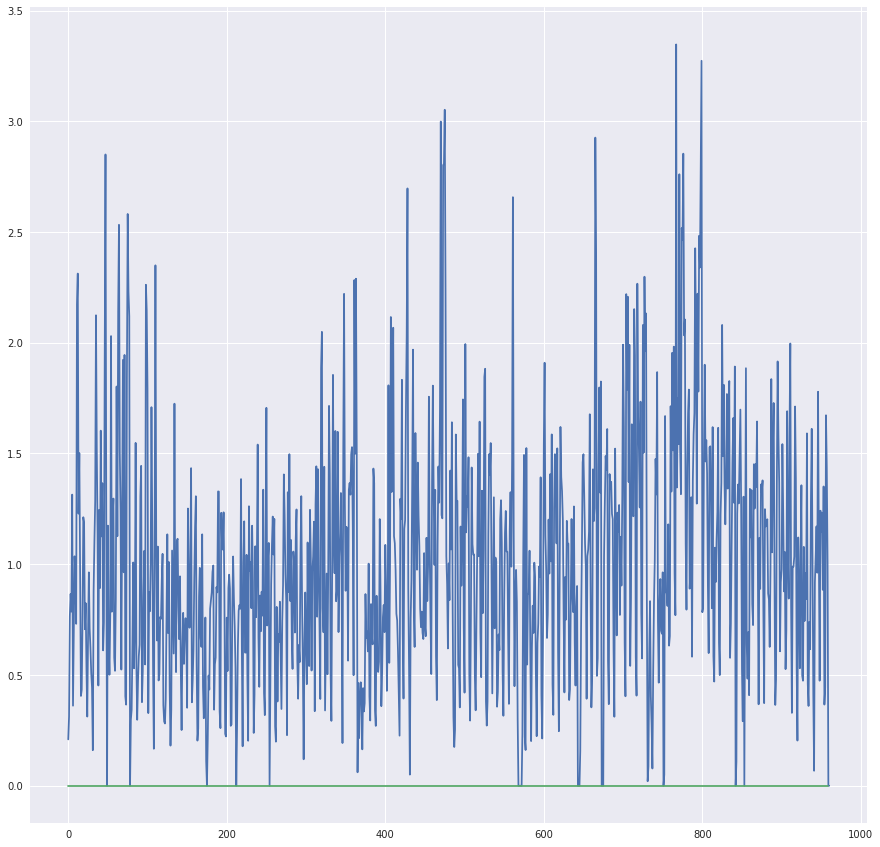

1

In [139]:
len(PlotWithChanges(0))

In [166]:
indices_where_algorith_was_wrong = df_pivot[:50][df_pivot.changes != df_pivot.changes_new].index

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [167]:
indices_where_algorith_was_wrong

Index([5, 14, 21, 25, 38, 45, 47, 53, 55, 56, 58, 60], dtype='object', name='ATM_ID')

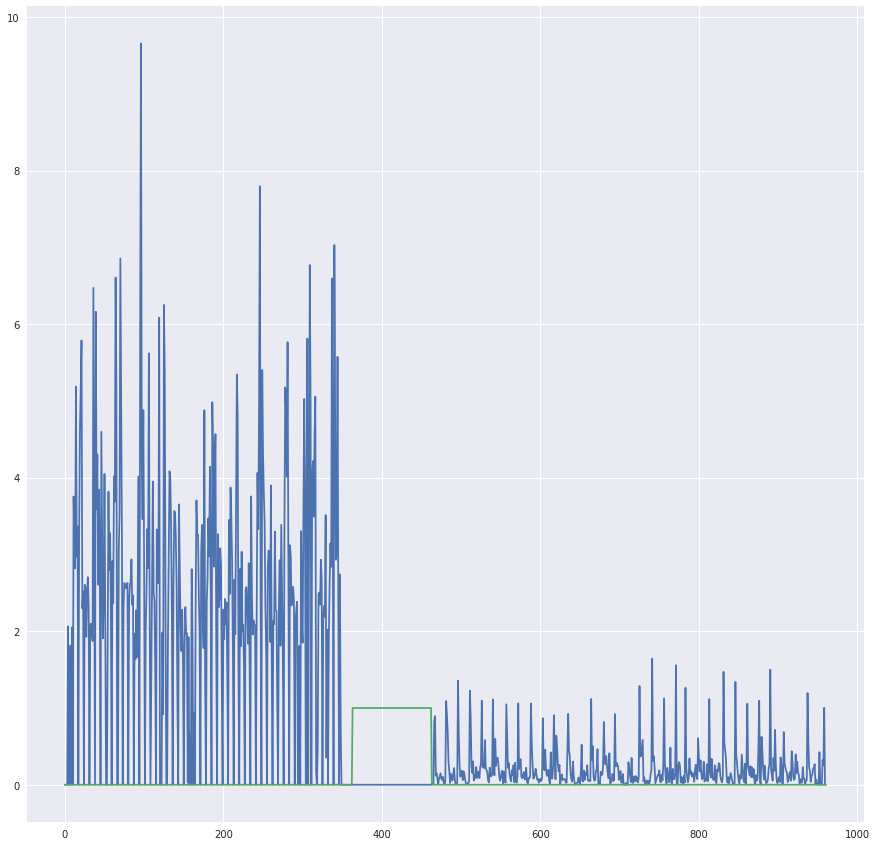

[[0, 353], [463, 960]]

In [168]:
PlotWithChanges(8)

In [15]:
# for i in indices_where_algorith_was_wrong:
#     print(i)
#     PlotWithChanges(i)

In [125]:
changes_dict = {
    4 : 1,
    8 : 1,
    10 : 2,
    17 : 2,
    18 : 1,
    21 : 1,
    22 : 1,
    23 : 1,
    24 : 1,
    32 : 1,
    44 : 1,
    48 : 2,
    52 : 2,
    55 : 2,
    56 : 1,
    57 : 1,
    60 : 1,
}

In [126]:
df_pivot['changes'] = 1

In [127]:
for key, value in changes_dict.items():
    df_pivot.loc[key, 'changes'] = value + 1

## Plots

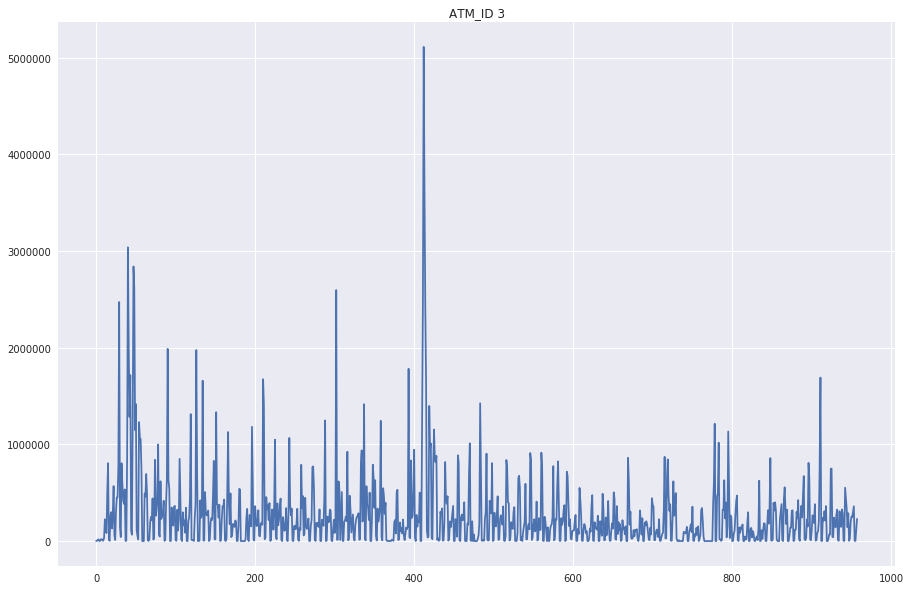

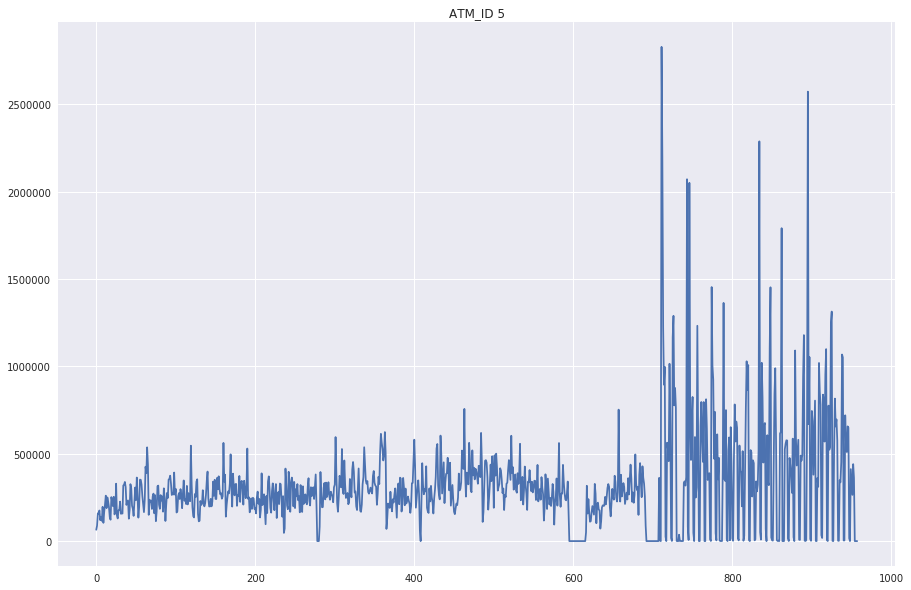

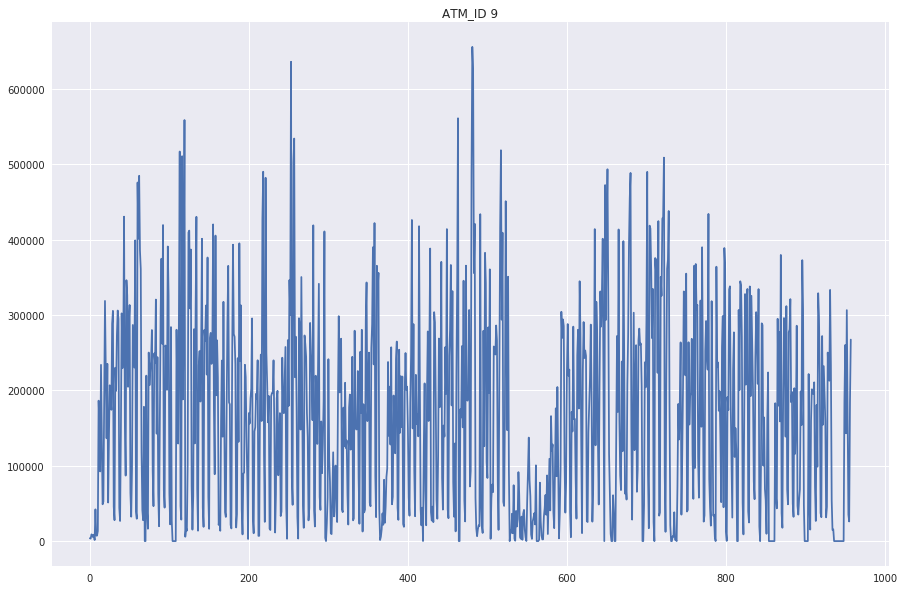

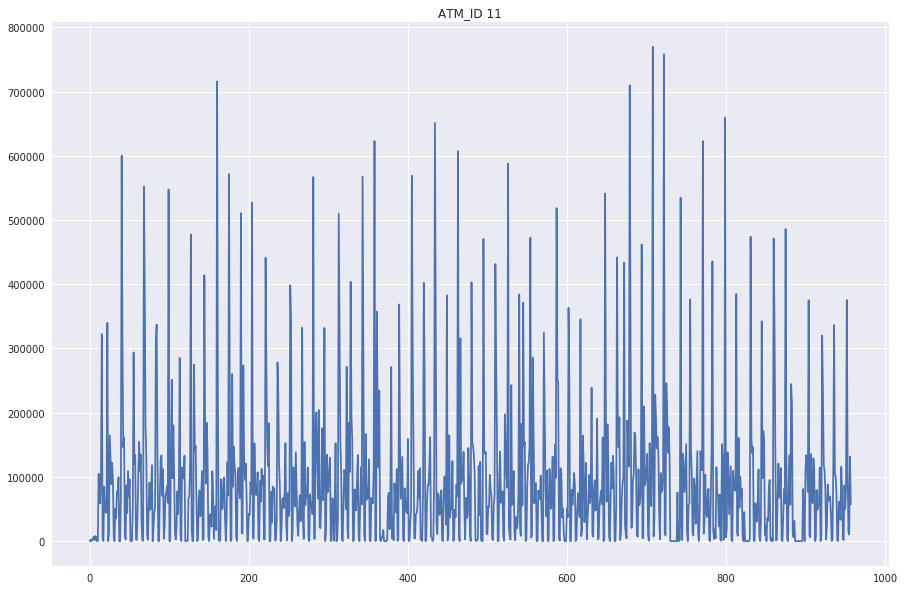

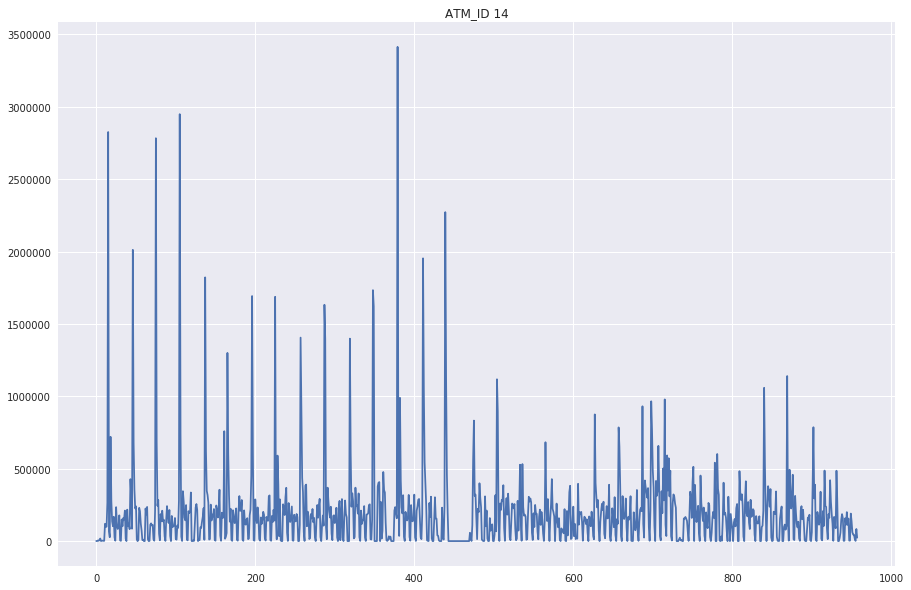

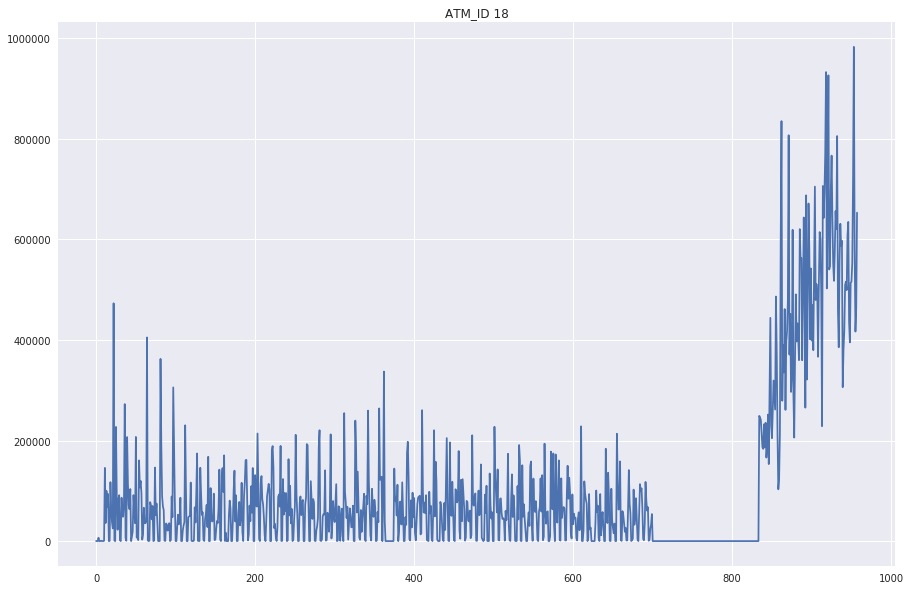

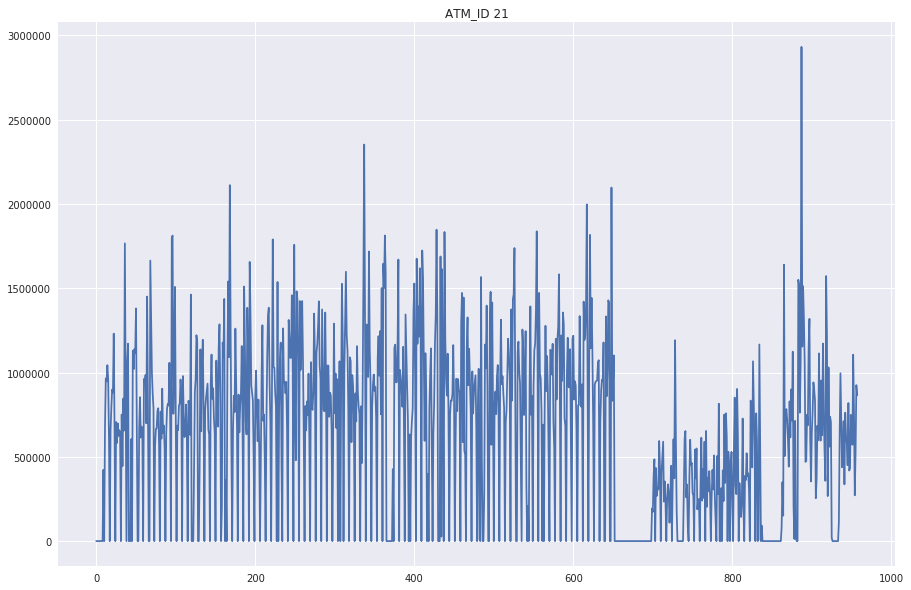

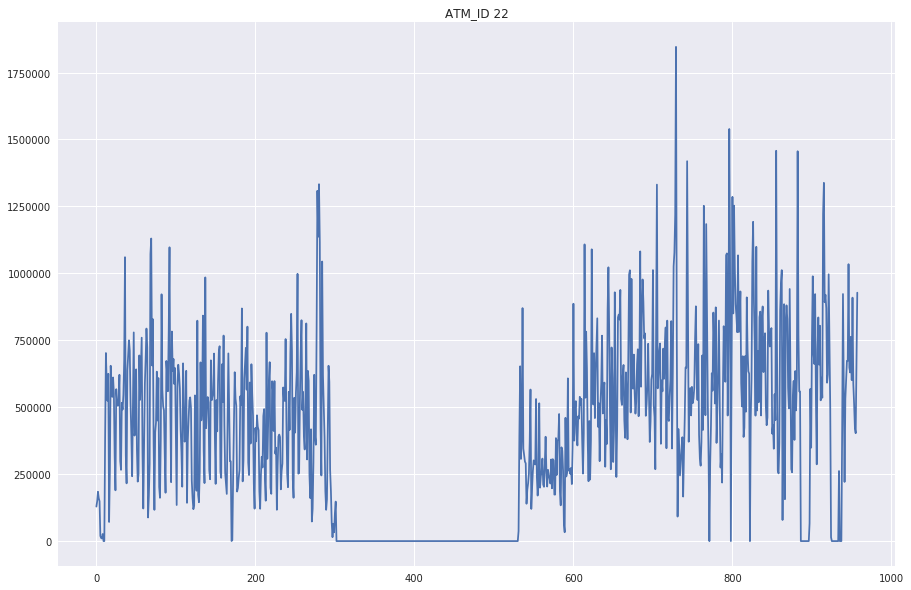

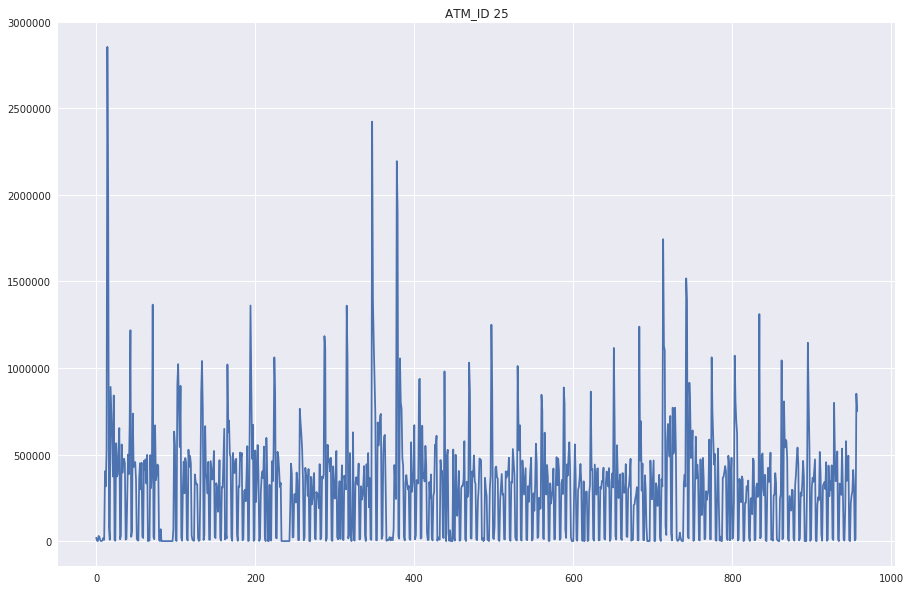

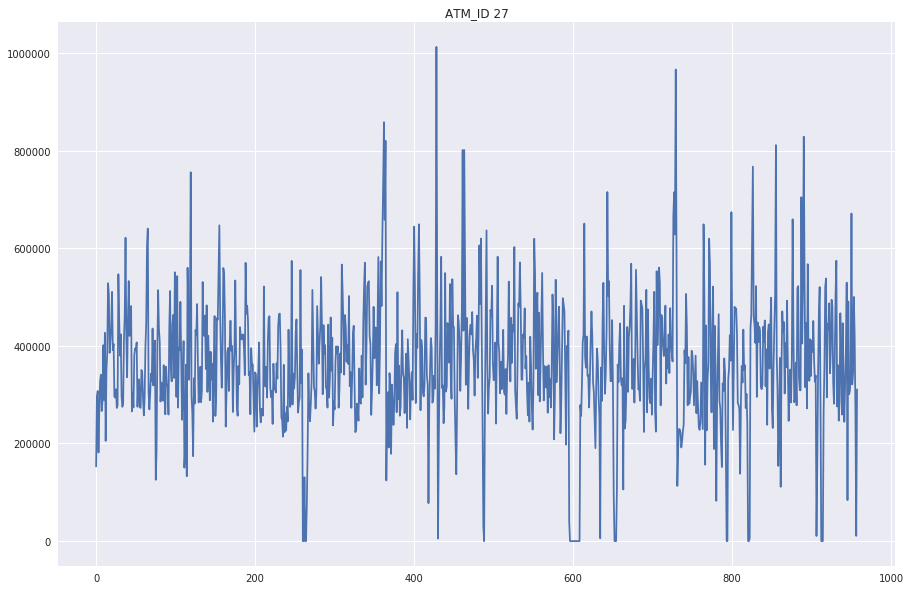

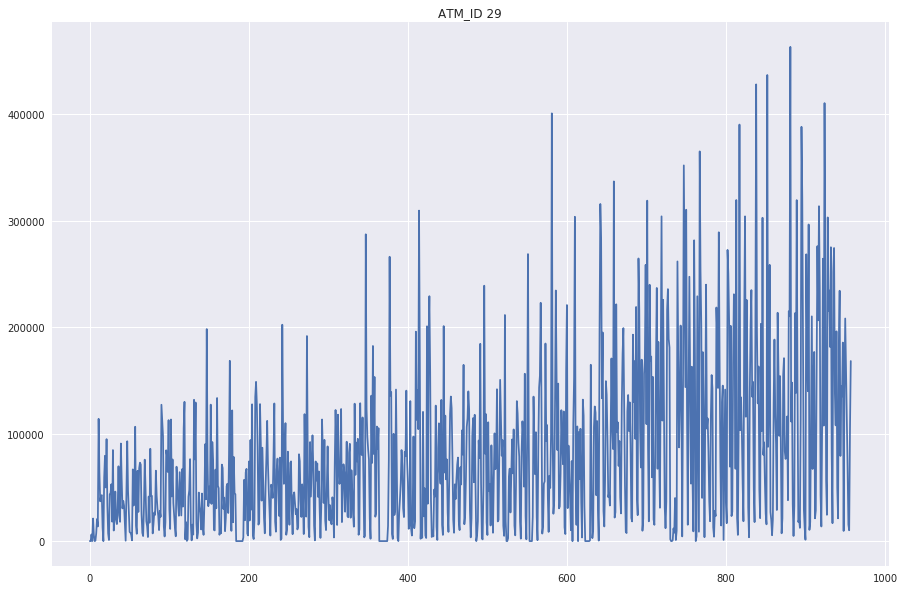

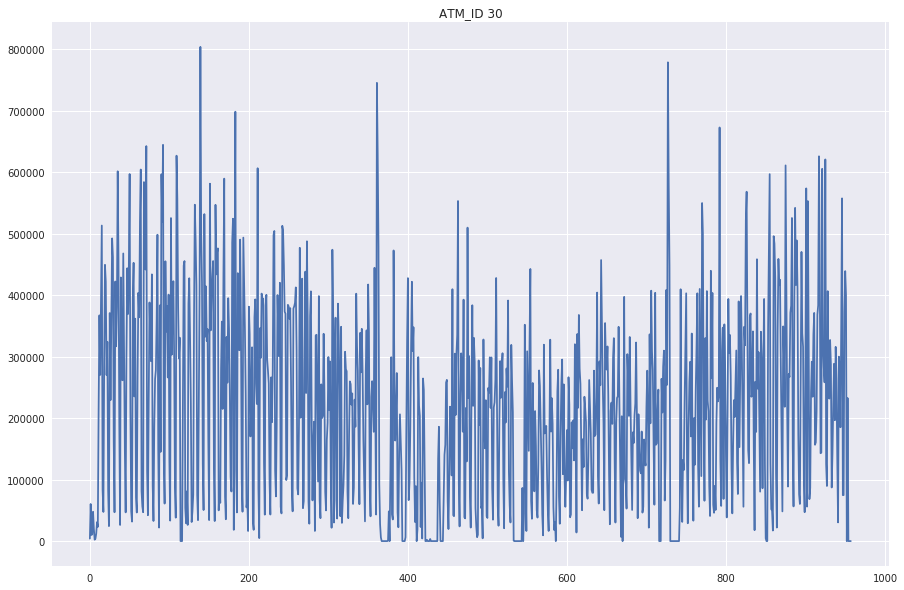

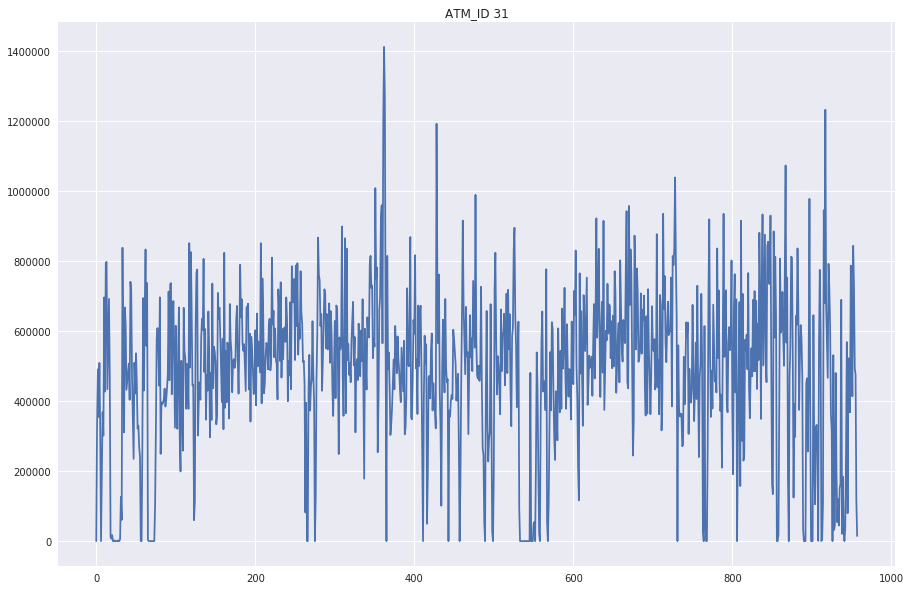

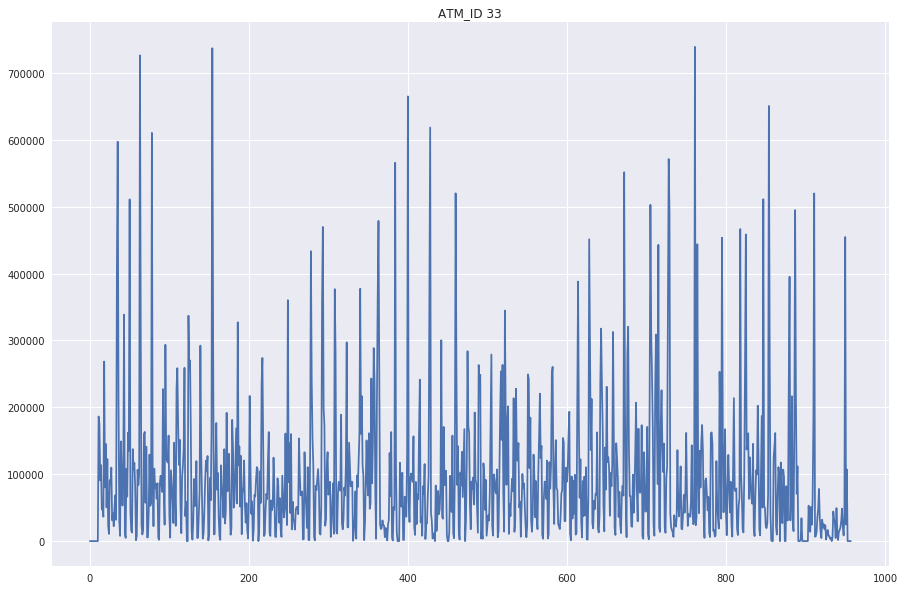

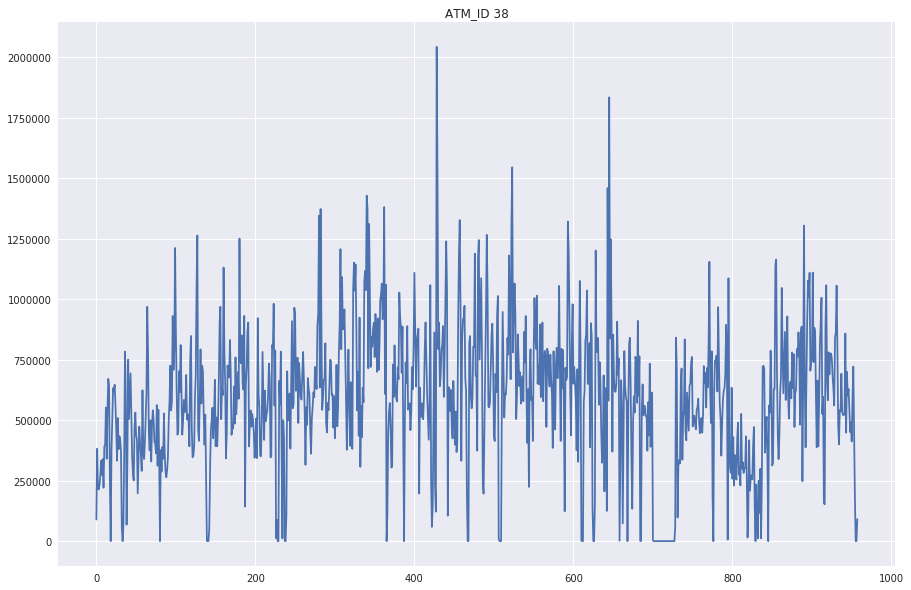

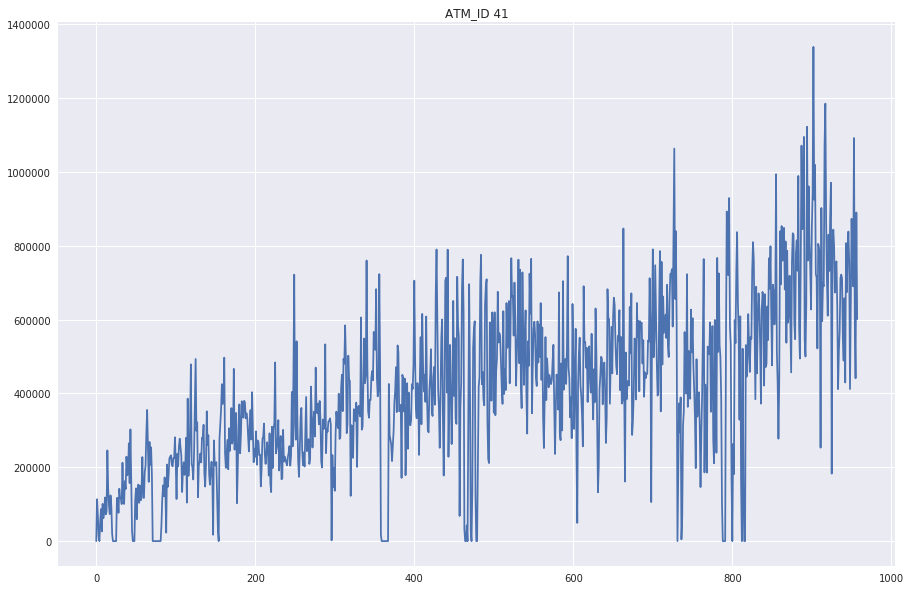

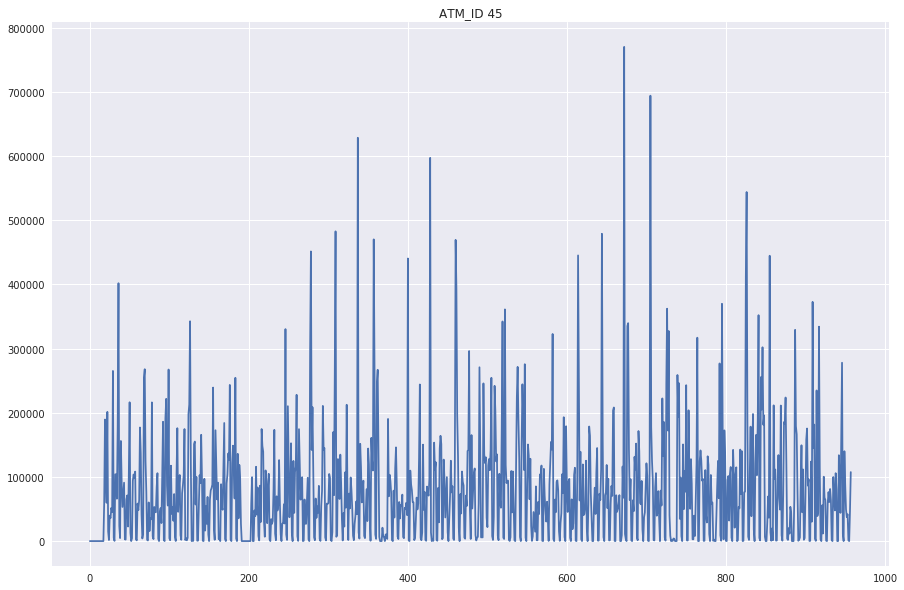

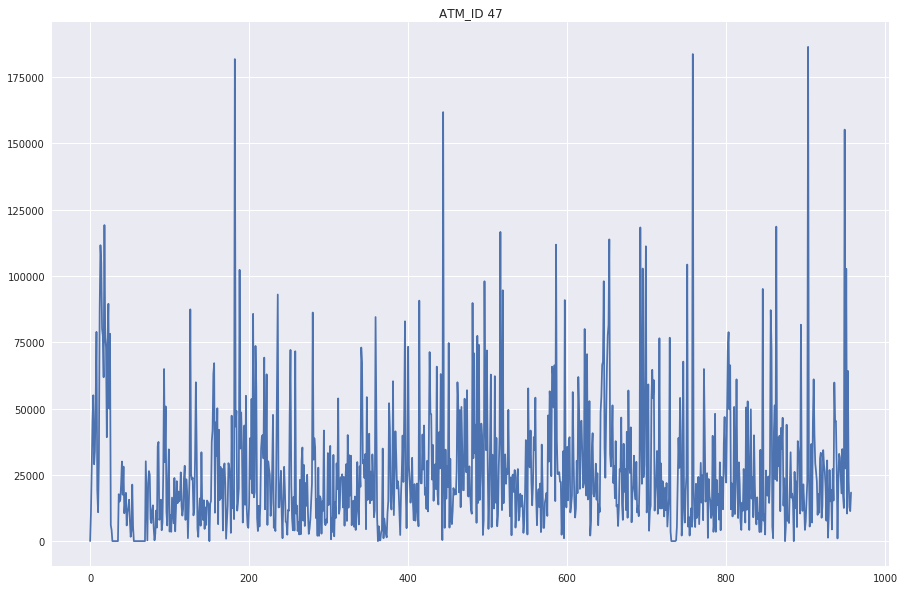

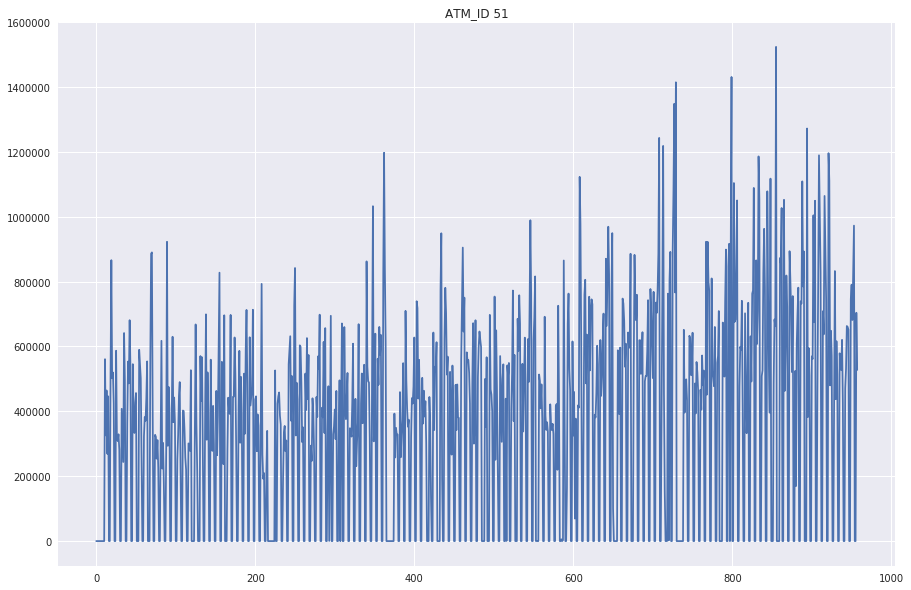

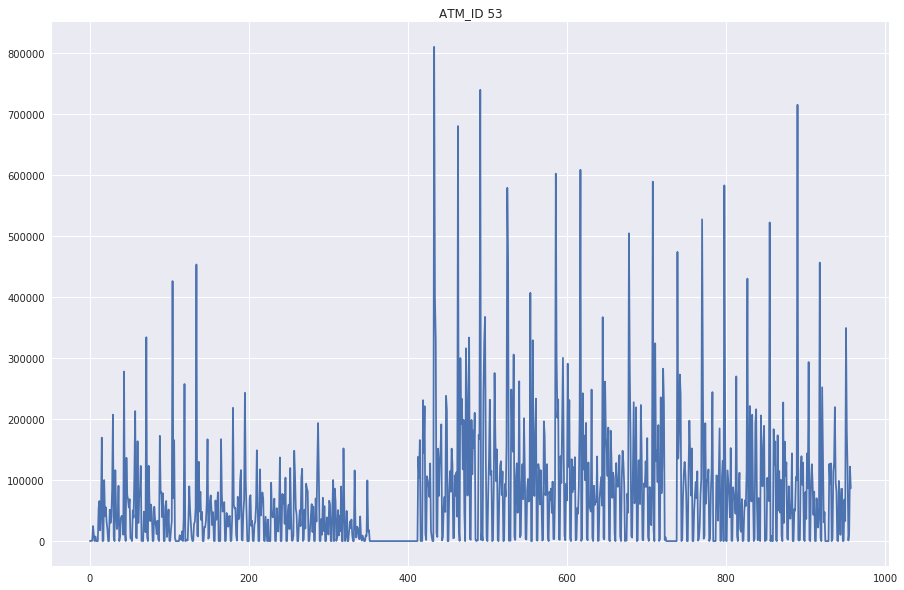

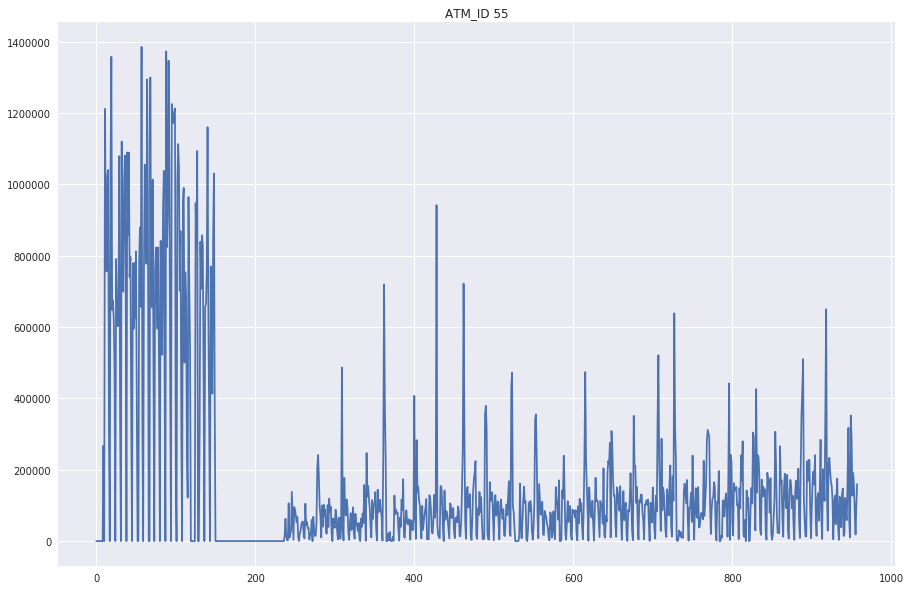

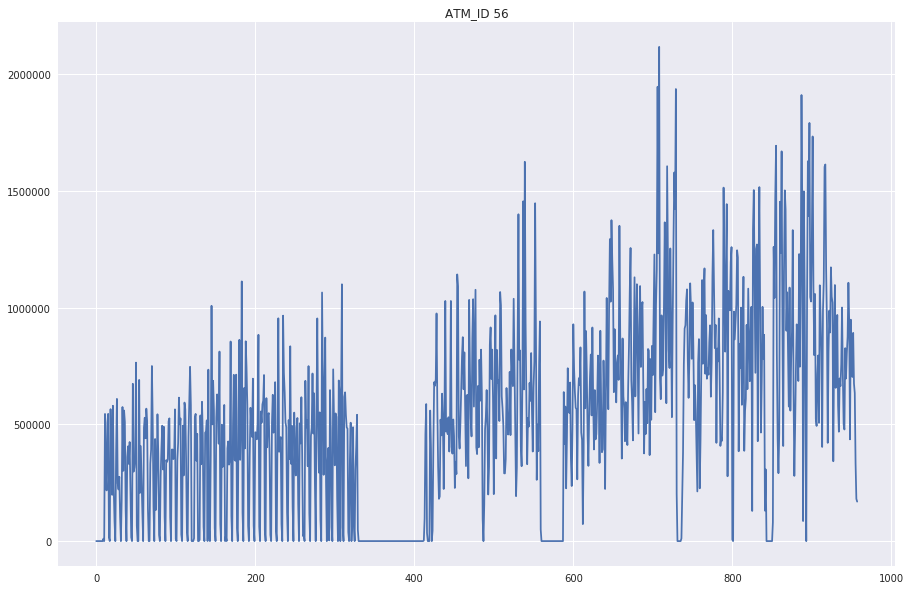

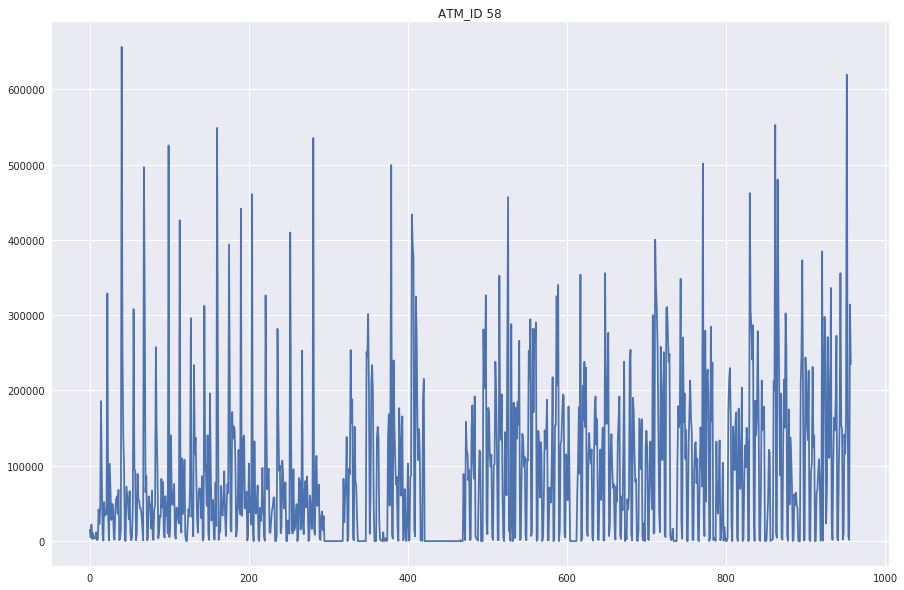

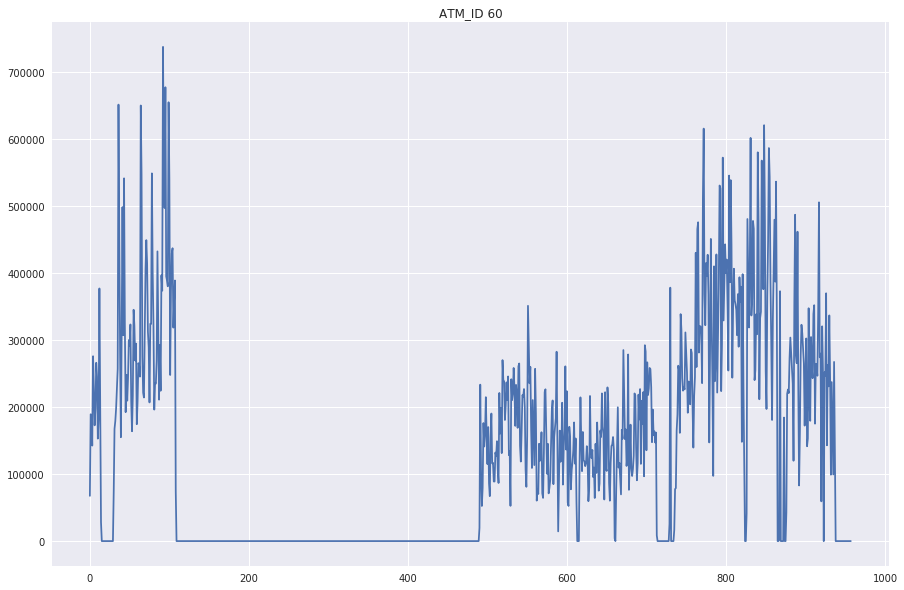

In [144]:
for x in indeces_where_algorith_was_wrong:
    plt.figure(figsize=(15,10))
    plt.title('ATM_ID {0}'.format(x))
    data = df[df.ATM_ID==x].CLIENT_OUT
    plt.plot(range(len(data)), data)
    plt.show()